In [2]:
import libs.forward_lib.angular_spectrum as AS

import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

from libs.forward_lib.modules.d2nn_models_new import *

In [3]:
def plot_complex_tensor(tensor, z_planes):
    num_planes = len(z_planes)

    plt.figure(figsize=(18, 6))

    for i, z_idx in enumerate(z_planes):
        intensity = torch.abs(tensor[z_idx]).square()
        normalized_intensity = (intensity - intensity.min()) / (intensity.max() - intensity.min() + 1e-12)
        phase = torch.angle(tensor[z_idx])

        plt.subplot(2, num_planes, i + 1)
        plt.imshow(intensity, cmap='gray')
        plt.axis('off')
        # plt.colorbar()
        plt.title(f'I: {z_idx}')

        plt.subplot(2, num_planes, num_planes + i + 1)
        plt.imshow(phase, cmap='hsv')
        plt.axis('off')
        # plt.colorbar()
        plt.title(f'P: {z_idx}')

    plt.subplots_adjust(top=0.73)
    plt.show()

In [4]:
lambda_= 532.0/ 1000 #um
k = 2 * torch.pi / lambda_ #rad/um
dx, dy, dz= 0.25, 0.25, 0.25 #um
Nx, Ny, Nz = 128, 128, 32
NA = 0.8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
cfg = {
     'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
     'model': 'd2nnASwWindow',
     'RI_Gel': 1,
     'lambda_': lambda_ * 1e-06,
     'n_layers': 2,
     'delta_z': 3.3e-06,
     'in_dist': 3.3e-06,
     'out_dist': 3.3e-06, 
     'neuron_size': dx * 1e-06,
    
     'img_size': Nx,
     'shrink_factor': 1,

     'torch_seed': 5, 
     'learn_type': 'phase',

     'quant_after': -1,
     'schedule_start': 1,
     'schedule_increment': 0.05,
     'schedule_every': 1,
    
     'full_precision_and_range': True,
     'unwrapped_phase': True,
     'pretrained': False,
     'no_quant': False,
     'mlsq': False,
     'dsq': False,
     'gs_quant': False,
     'hard_quant': False,
     'inq': False,
     'mlsq_inq': False,
     'fake_quant': False,
    
     'quant_levels': [2, 7],
     'lower_bound': 0,
     'upper_bounds': [0.5340707511102649, 3.267256359733385],
     'learn_u': [False, False],
     'alpha': 0,
     'learn_schedule': False,
     'mlsq_reg': [0.01, 0.1],
     'reg_schedule': ['pow2', 5],
    
     'dsq_alpha': 0.2,
     'dsq_factor': 10,
     'dsq_regularize': [0.01, 0.5],
     'dsq_temp_const': False,
     'dsq_temp_learn': True,
     'int_ramp': 'no',
    
     'window_size': 4,
     'biasOnoise': 0,
     'energy_type': 'passive',
     'samples': 1,
     'local_norm_amp': False,

     'photon_count': 1,

     'fab_noise': 0,
     'dz_noise': 0,
     'dx_noise': 0,
     'step_noise': 0,
     'rigid_structure': False,
     'sf_noise': False,
     'default_sf': 'nan',
     'error_analysis': False,
     'phase_error': 0,
     'dz_error': 0,
     'dx_error': 0,
    
     'quant_interval': None,
     'epochs': 1,
     'weight_sf': 1,
     'output_scalebias_matrix': False,
     'output_scalebias_for_INTENSITY': False,
     'output_scale': 1.0,
     'output_bias': 0.0,
     'output_scale_learnable': False,
     'output_bias_learnable': False,
}

scheduler = torch.arange(cfg['schedule_start'], 1+cfg['schedule_start']+(10-cfg['quant_after'])//cfg['schedule_every']*\
                         cfg['schedule_increment'], cfg['schedule_increment'])
cfg['schedule_array'] = scheduler

In [6]:
def d2nn_propagation(model, input_field, device, cfg):
    img_size   = cfg['img_size']
    samples    = cfg['samples']
    shrinkFactor = cfg['shrink_factor'] if 'shrink_factor' in cfg.keys() else 1

    if(shrinkFactor!=1):
        csize = int((img_size*samples)/shrinkFactor)
        spos  = int((img_size*samples - csize)/2)
        epos  = spos + csize
    else:
        spos = 0
        epos = img_size*samples

    if cfg['error_analysis']:
        cfg['eff_neuron_size'] = cfg['neuron_size'] + cfg['dx_error'] 
        cfg['eff_layer_dist']  = cfg['delta_z'] + cfg['dz_error']
    else:
        cfg['eff_neuron_size']  =  cfg['neuron_size'] + (2 * cfg['dx_noise'] * torch.rand(1).item() - cfg['dx_noise']) #add neuron size noise N_f ~ U[-self.dx_noise, self.dx_noise]
        cfg['eff_layer_dist']   =  cfg['delta_z']     + (2 * cfg['dz_noise'] * torch.rand(1).item() - cfg['dz_noise']) #add interlayer distance noise N_f ~ U[-self.dz_noise, self.dz_noise]
        cfg['step_noise_value'] =  (2 * cfg['step_noise'] * torch.rand(1).item() - cfg['step_noise']) #phase step noise N_f ~ U[-self.dp_noise, self.dp_noise]
        # cfg['eff_phase_delta']  =  eval(cfg['phase_delta']) + cfg['step_noise_value']

    ground_truth = (input_field.unsqueeze(0)).to(device)
    model.eval()
    with torch.no_grad():
        pred_img, out_bias,out_scale, temp, mask_list = model(ground_truth, 0, 0, cfg)
        pred_img = pred_img[:,spos:epos,spos:epos] # Crop the pred image
    return pred_img


def get_D2NN_model(): 
    torch.manual_seed(cfg['torch_seed']) 
    model = eval(cfg['model'])(cfg).to(cfg['device'])
    return model

def get_field_at_out(input_field, D2NN_model):
    field = torch.tensor([]).to(cfg['device'])
    field = d2nn_propagation(D2NN_model, input_field, cfg['device'], cfg = cfg) 
    return field.squeeze()

In [7]:
D2NN_model = get_D2NN_model()

D2NN output for a given input field

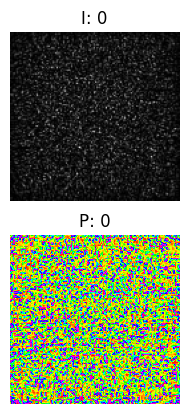

In [8]:
input_field = torch.ones(Nx, Nx) * torch.exp(1j*torch.zeros(Nx, Nx)) 
field_out = get_field_at_out(input_field, D2NN_model)
plot_complex_tensor(field_out.unsqueeze(0), range(0, 1))

Propogate D2NN output field using angluar spectrum

In [9]:
def propogate_field(input_field, Nx, Ny, Nz, dx, dy, dz, w=8, mask_factor=NA**2):
    aNs = AS.d2nnASwWindow_layer(Nx, Ny, dx, dy, dz, lambda_, window_size=w)
    H1 = torch.zeros(Nz,Nx,Ny,dtype=torch.complex64)
    shift = cfg['delta_z']/2 + cfg['out_dist']
    shift = 0
    for i in range(0, Nz):
        prop_dist = dz*(i-Nz//2) - shift*1e06
        aNs.find_transfer_function(prop_dist, mask_factor_=mask_factor)
        output_field = aNs.forward(input_field.cpu().unsqueeze(0))
        H1[i] = output_field.detach()
    return H1

H1 = propogate_field(field_out,Nx,Ny,Nz,dx,dy,dz,8,mask_factor=NA**2)

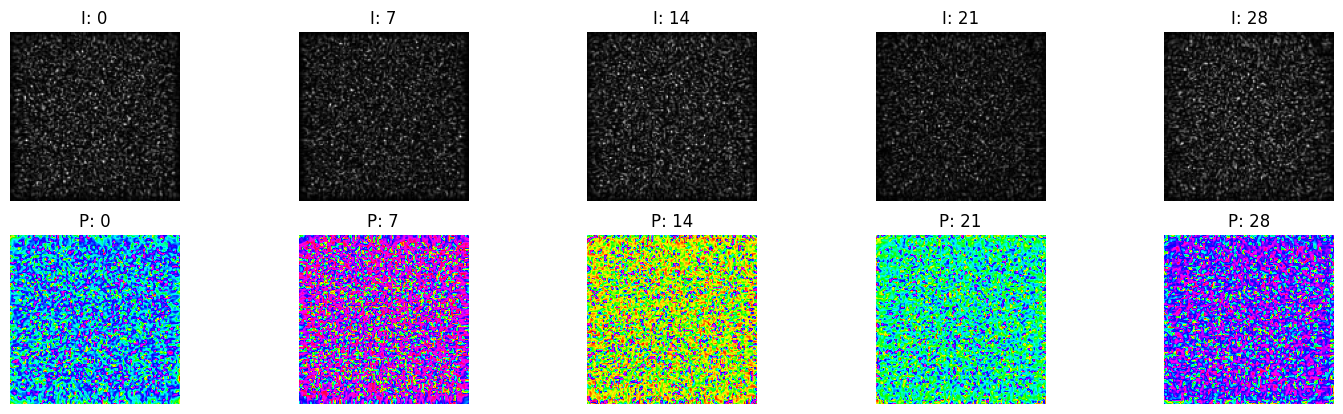

In [10]:
plot_complex_tensor(H1, range(0, Nz, 7))

Checking symmetry

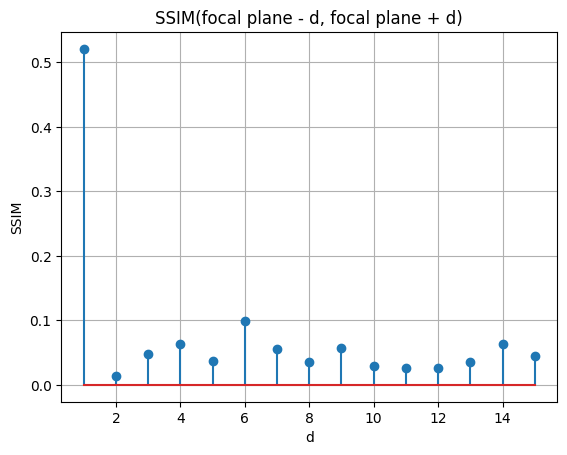

In [11]:
ssim_values = []
ds = []

d = 1
while (Nz//2 - d > 0 and Nz//2 + d < Nz):
    l = torch.abs(H1[Nz//2 - d]).square().numpy()
    r = torch.abs(H1[Nz//2 + d]).square().numpy()
    ssim_d = ssim(l, r, data_range=np.max(r)-np.min(r))
    ssim_values.append(ssim_d)
    ds.append(d)
    d += 1

plt.stem(ds, ssim_values)
plt.title(f"SSIM(focal plane - d, focal plane + d)")
plt.xlabel('d')
plt.ylabel('SSIM')
plt.grid(True)
plt.show()

Check similarity between adjascent planes

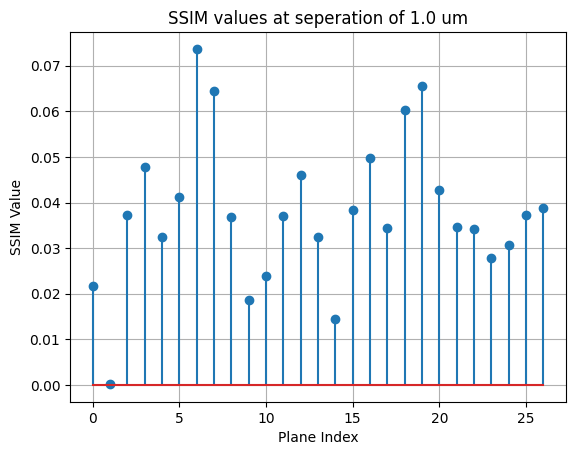

In [12]:
ssim_values = []
indices = []
step = 4

for i in range(0, Nz-1-step, 1):
    plane_i = torch.abs(H1[i]).square().numpy()
    plane_i_plus_n = torch.abs(H1[i+step]).square().numpy()
    ssim_i = ssim(plane_i, plane_i_plus_n, data_range=np.max(plane_i_plus_n)-np.min(plane_i_plus_n))
    ssim_values.append(ssim_i)
    indices.append(i)

plt.stem(indices, ssim_values)
plt.title(f"SSIM values at seperation of {step*dz} um")
plt.xlabel('Plane Index')
plt.ylabel('SSIM Value')
plt.grid(True)
plt.show()

Simulate differnet input fields for each measurments (Angle scan)

Maximum off-diagonal SSIM score:
tensor(0.3225)


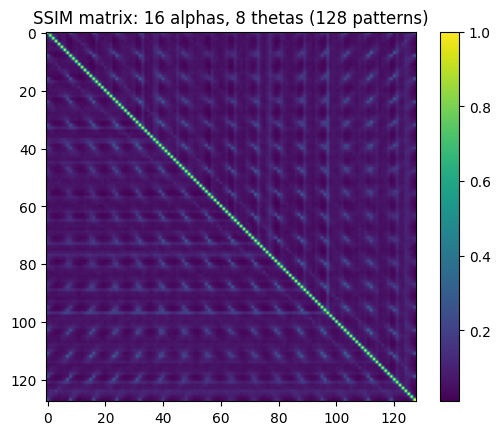

In [13]:
# 128 patterns
n_alphas = 16
n_thetas = 8
n_patterns = n_alphas * n_thetas

alphas = torch.arange(0, torch.pi, torch.pi/n_alphas)

delta = torch.pi/10
thetas_1 = torch.linspace(0+delta, torch.pi/2-delta, n_thetas//2)
thetas_2 = torch.linspace(torch.pi/2+delta, torch.pi-delta, n_thetas-n_thetas//2)
thetas = torch.cat((thetas_1, thetas_2))

xx = torch.arange(Nx).unsqueeze(0).repeat(Nx, 1) * dx
yy = torch.arange(Ny).unsqueeze(1).repeat(1, Ny) * dy

field_out_list = []
corr_mat = torch.zeros(n_patterns, Nx*Ny)

for i in range(n_alphas):
    alpha_i = alphas[i]
    ysina_xcosa = yy*torch.sin(alpha_i) + xx*torch.cos(alpha_i)
    for j in range(n_thetas):
        theta_j = thetas[j]
        phi_xy = k * ysina_xcosa * torch.cos(theta_j)
        input_field_ij = torch.ones(Nx, Ny) * torch.exp(1j * phi_xy)
        field_out_ij = get_field_at_out(input_field_ij, D2NN_model)
        field_out_list.append(field_out_ij)
        intensity_ij = torch.abs(field_out_ij).square()
        corr_mat[n_thetas*i+j, :] = intensity_ij.flatten()
        

ssim_matrix = torch.zeros(n_patterns, n_patterns)
for i in range(n_patterns):
    intensity_i = torch.abs(field_out_list[i]).square().numpy()
    for j in range(i, n_patterns):
        intensity_j = torch.abs(field_out_list[j]).square().numpy()
        ssim_val = ssim(intensity_i, intensity_j, data_range=np.max(intensity_j)-np.min(intensity_j))
        ssim_matrix[i, j] = ssim_val
        ssim_matrix[j, i] = ssim_val

print("Maximum off-diagonal SSIM score:")
mask = ~torch.eye(ssim_matrix.size(0), dtype=bool, device=ssim_matrix.device)
print(torch.max(ssim_matrix[mask]))   

plt.imshow(ssim_matrix, cmap='viridis')
plt.title(f"SSIM matrix: {n_alphas} alphas, {n_thetas} thetas ({n_patterns} patterns)")
plt.colorbar()
plt.show()

Maximum off-diagonal correlation value:
tensor(0.2774)


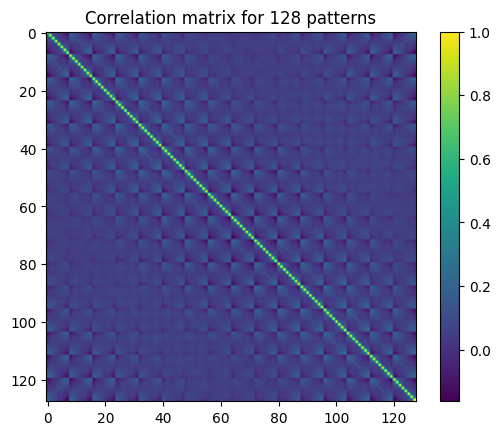

In [14]:
correlation_matrix = torch.corrcoef(corr_mat)

print("Maximum off-diagonal correlation value:")
mask = ~torch.eye(correlation_matrix.size(0), dtype=bool, device=correlation_matrix.device)
print(torch.max(correlation_matrix[mask]))

plt.imshow(correlation_matrix, cmap='viridis')
plt.title(f"Correlation matrix for {n_patterns} patterns")
plt.colorbar()
plt.show()

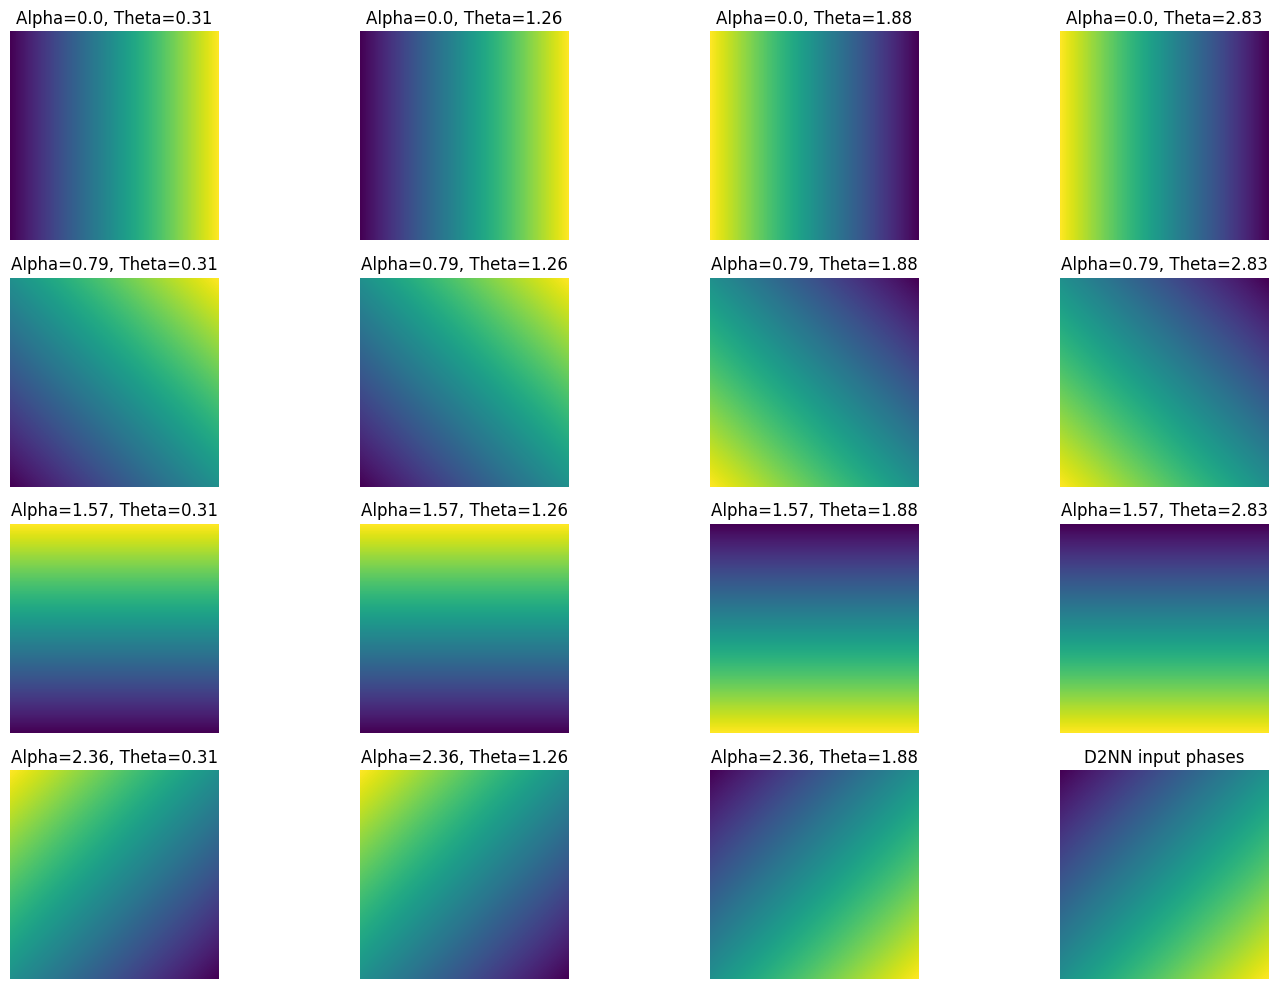

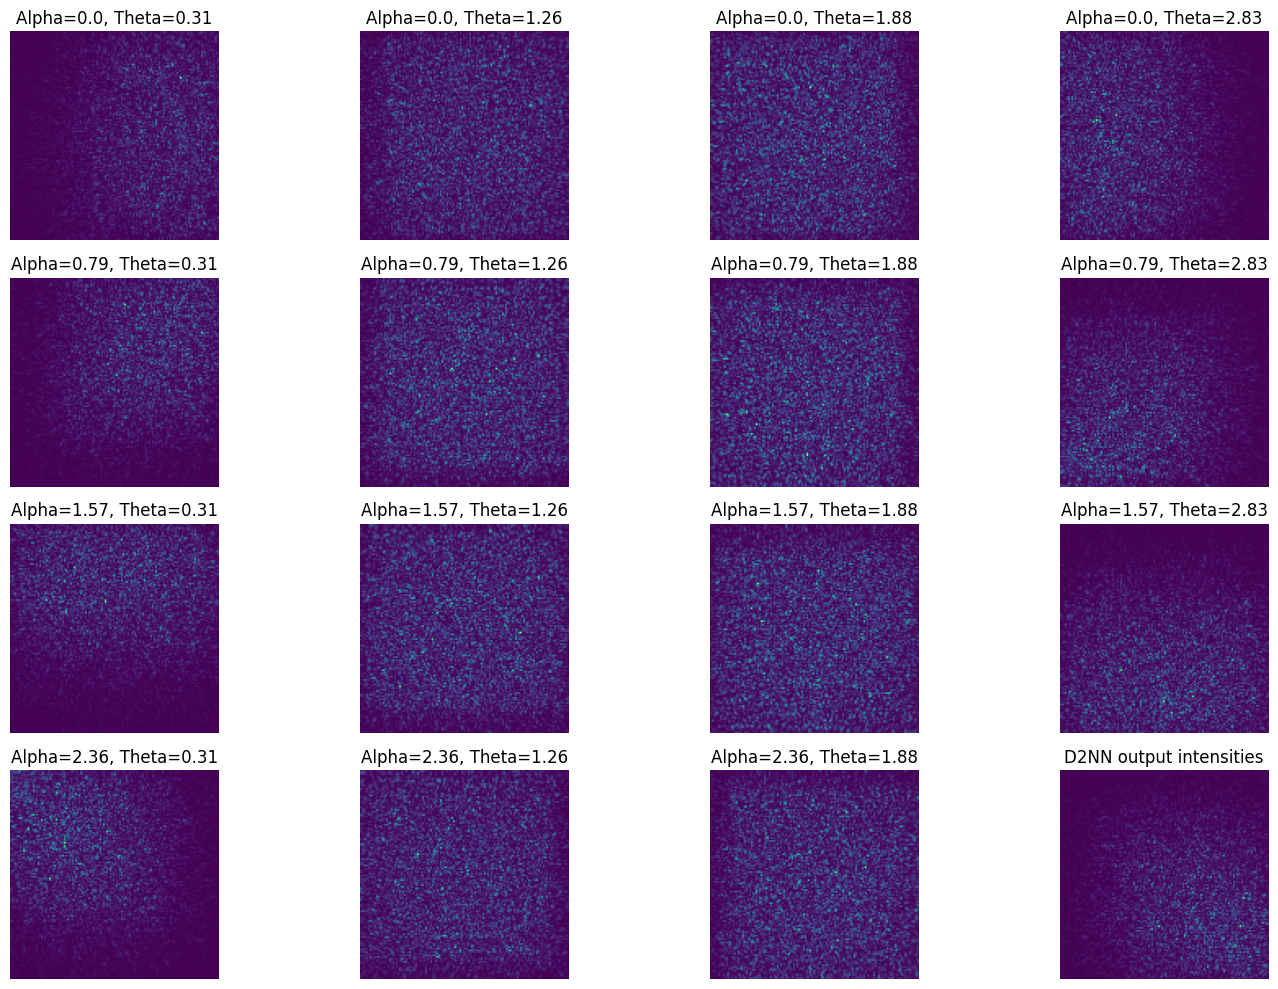

In [17]:
import matplotlib.pyplot as plt

# 16 patterns
n_alphas = 4
n_thetas = 4
n_patterns = n_alphas * n_thetas

alphas = torch.arange(0, torch.pi, torch.pi/n_alphas)

delta = torch.pi/10
thetas_1 = torch.linspace(0+delta, torch.pi/2-delta, n_thetas//2)
thetas_2 = torch.linspace(torch.pi/2+delta, torch.pi-delta, n_thetas-n_thetas//2)
thetas = torch.cat((thetas_1, thetas_2))

xx = torch.arange(Nx).unsqueeze(0).repeat(Nx, 1) * dx
yy = torch.arange(Ny).unsqueeze(1).repeat(1, Ny) * dy

field_out_list = []
corr_mat = torch.zeros(n_patterns, Nx*Ny)

fig, axes = plt.subplots(n_alphas, n_thetas, figsize=(15, 10))
for i in range(n_alphas):
    alpha_i = alphas[i]
    ysina_xcosa = yy*torch.sin(alpha_i) + xx*torch.cos(alpha_i)
    for j in range(n_thetas):
        theta_j = thetas[j]
        phi_xy = k * ysina_xcosa * torch.cos(theta_j)
        ax = axes[i, j]
        ax.imshow(phi_xy, cmap='viridis', origin='lower')
        ax.set_title(f'Alpha={round(alpha_i.item(), 2)}, Theta={round(theta_j.item(), 2)}')
        ax.axis('off')
plt.title("D2NN input phases")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(n_alphas, n_thetas, figsize=(15, 10))
for i in range(n_alphas):
    alpha_i = alphas[i]
    ysina_xcosa = yy*torch.sin(alpha_i) + xx*torch.cos(alpha_i)
    for j in range(n_thetas):
        theta_j = thetas[j]
        phi_xy = k * ysina_xcosa * torch.cos(theta_j)
        input_field_ij = torch.ones(Nx, Ny) * torch.exp(1j * phi_xy)
        field_out_ij = get_field_at_out(input_field_ij, D2NN_model)
        intensity_ij = torch.abs(field_out_ij).square()
        ax = axes[i, j]
        ax.imshow(intensity_ij, cmap='viridis', origin='lower')
        ax.set_title(f'Alpha={round(alpha_i.item(), 2)}, Theta={round(theta_j.item(), 2)}')
        ax.axis('off')
        field_out_list.append(field_out_ij)
        corr_mat[n_thetas*i+j, :] = intensity_ij.flatten()
plt.title("D2NN output intensities")
plt.tight_layout()
plt.show()


Maximum off-diagonal SSIM score:
tensor(0.2457)


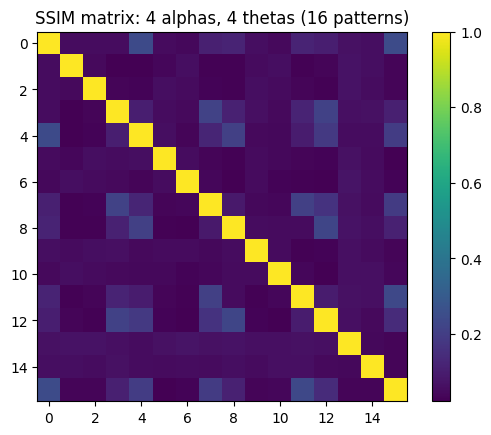

Maximum off-diagonal correlation value:
tensor(0.1680)


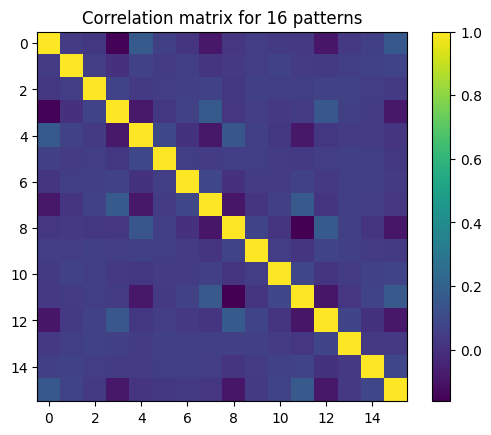

In [16]:
ssim_matrix = torch.zeros(n_patterns, n_patterns)
for i in range(n_patterns):
    intensity_i = torch.abs(field_out_list[i]).square().numpy()
    for j in range(i, n_patterns):
        intensity_j = torch.abs(field_out_list[j]).square().numpy()
        ssim_val = ssim(intensity_i, intensity_j, data_range=np.max(intensity_j)-np.min(intensity_j))
        ssim_matrix[i, j] = ssim_val
        ssim_matrix[j, i] = ssim_val

print("Maximum off-diagonal SSIM score:")
mask = ~torch.eye(ssim_matrix.size(0), dtype=bool, device=ssim_matrix.device)
print(torch.max(ssim_matrix[mask]))   

plt.imshow(ssim_matrix, cmap='viridis')
plt.title(f"SSIM matrix: {n_alphas} alphas, {n_thetas} thetas ({n_patterns} patterns)")
plt.colorbar()
plt.show()

correlation_matrix = torch.corrcoef(corr_mat)

print("Maximum off-diagonal correlation value:")
mask = ~torch.eye(correlation_matrix.size(0), dtype=bool, device=correlation_matrix.device)
print(torch.max(correlation_matrix[mask]))

plt.imshow(correlation_matrix, cmap='viridis')
plt.title(f"Correlation matrix for {n_patterns} patterns")
plt.colorbar()
plt.show()